In [1]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

image = Image.open("image.png").convert("RGB")
inputs = processor(image, return_tensors="pt")

caption = model.generate(**inputs)
decoded_caption = processor.decode(caption[0], skip_special_tokens=True)
print("Caption:", decoded_caption)

/Users/idilkpkrn/Desktop/recommender/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'image.png'

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Detected cat with 1.00 confidence.


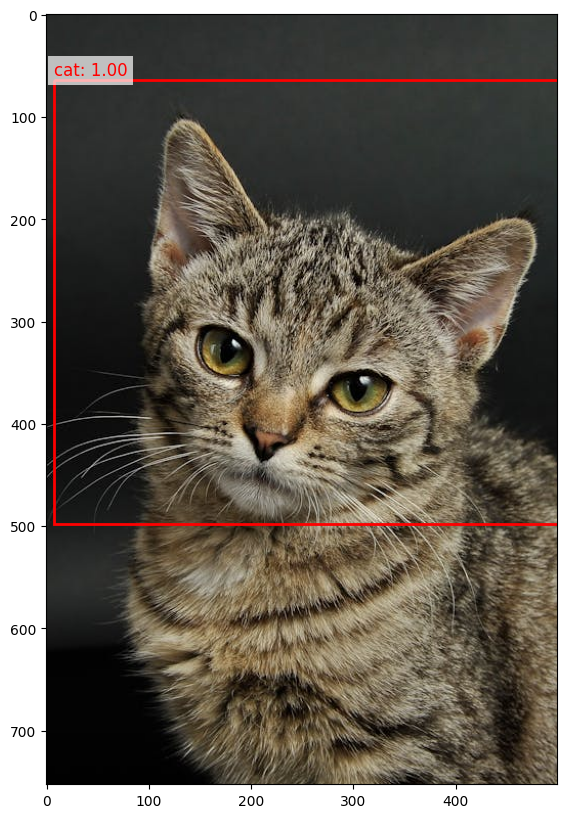

In [2]:
from transformers import DetrImageProcessor, DetrForObjectDetection, pipeline
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

inputs = detr_processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = detr_model(**inputs)

target_size = [(image.size[0], image.size[1])]

results = detr_processor.post_process_object_detection(outputs, target_sizes=target_size, threshold=0.9)
id2label = detr_model.config.id2label 

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
object_box = None
for result in results:
    for box, label, score in zip(result["boxes"], result["labels"], result["scores"]):
        xmin, ymin, xmax, ymax = box.tolist()
        object_box = box.tolist()
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label_text = f"{id2label[label.item()]}: {score:.2f}"
        ax.text(xmin, ymin - 5, label_text, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        print(f"Detected {id2label[label.item()]} with {score:.2f} confidence.")

plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw
from transformers import (
    AutoImageProcessor, MaskFormerForInstanceSegmentation
)

seg_processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-coco")
seg_model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-coco")

/Users/idilkpkrn/Desktop/recommender/.virtualenv/lib/python3.11/site-packages/transformers/utils/deprecation.py:165: FutureWarning: `max_size` is deprecated and removed starting from version 4.27.0 for `MaskFormerImageProcessor.__init__`.
  return func(*args, **kwargs)


In [24]:
xmin, ymin, xmax, ymax = object_box
cropped_image = image.crop((xmin, ymin, xmax, ymax))

seg_inputs = seg_processor(images=cropped_image, return_tensors="pt")
with torch.no_grad():
    seg_outputs = seg_model(**seg_inputs)

seg_logits = seg_outputs.class_queries_logits[0]  # Class predictions
seg_masks = seg_outputs.masks_queries_logits[0]
seg_labels = torch.argmax(seg_logits, dim=-1).cpu().numpy()

label_to_name = seg_model.config.id2label
part_masks = {}
for i, label in enumerate(seg_labels):
    part_name = label_to_name.get(label, "unknown")
    part_masks[part_name] = seg_masks[i].cpu().numpy()

print(part_name)

unknown


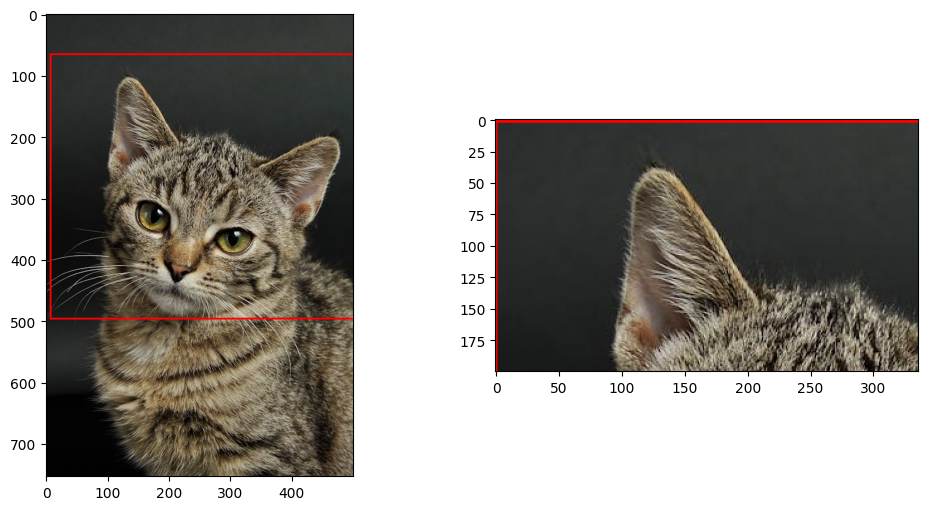

In [41]:
target_part = "unknown"
if target_part in part_masks:
    target_mask = part_masks[target_part]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[1].imshow(cropped_image)
    ax[1].imshow(target_mask, alpha=0.0)

    plt.show()

In [2]:
from transformers import CLIPProcessor, CLIPModel, pipeline
from PIL import Image
import torch
import matplotlib.pyplot as plt

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

segmentation_pipeline = pipeline("image-segmentation", model="facebook/mask2former-swin-large-coco-instance")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/Users/idilkpkrn/Desktop/recommender/.virtualenv/lib/python3.11/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)
Device set to use mps:0


In [9]:
image = Image.open("image.png").convert("RGB")

def align_text_with_image(image, user_input):
    inputs = clip_processor(text=[user_input], images=image, return_tensors="pt", padding=True)

    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image 
    probs = logits_per_image.softmax(dim=1)      
    
    return probs.item()

user_input = "ear"
alignment_score = align_text_with_image(image, user_input)
print(f"Alignment score for '{user_input}': {alignment_score}")

Alignment score for 'ear': 1.0


`label_ids_to_fuse` unset. No instance will be fused.


Best segment label: cat


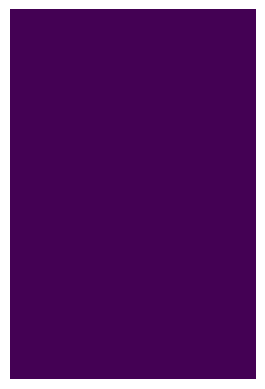

`label_ids_to_fuse` unset. No instance will be fused.


Best segment label: cat


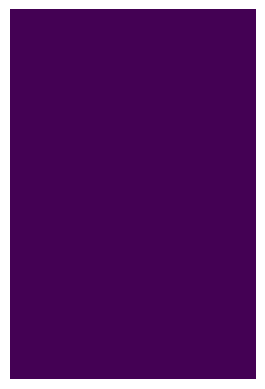

In [12]:
def segment_image(image, user_input):
    segments = segmentation_pipeline(image)
    
    best_segment = None
    best_score = -1
    
    for segment in segments:
        segment_label = segment['label']
        segment_image = segment['mask'].convert("RGB")
        
        score = align_text_with_image(segment_image, user_input)
        
        if score > best_score:
            best_score = score
            best_segment = segment
    
    return best_segment

# Example usage
user_input = "cat ear"
best_segment = segment_image(image, user_input)

if best_segment:
    print(f"Best segment label: {best_segment['label']}")
    plt.imshow(best_segment['mask'])
    plt.axis('off')
    plt.show()
else:
    print("No matching segment found.")
def visualize_part(image_path, user_input):
    image = Image.open(image_path)
    
    best_segment = segment_image(image, user_input)
    
    if best_segment:
        print(f"Best segment label: {best_segment['label']}")
        plt.imshow(best_segment['mask'])
        plt.axis('off')
        plt.show()
    else:
        print("No matching segment found.")

image_path = "image.png"
user_input = "ear"
visualize_part(image_path, user_input)